# ЗАДАЧА

Построить модель, которая хороше предскажет количество продаж каждой единицы товара в каждом штате за месяц. 

Посмотрим 2 модели: linear regression и random forest.


# РЕШЕНИЕ

## Загрузка данных

In [ ]:
!python --version

Python 3.7.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install -q pyspark

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
import shutil

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.feature import MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
path = "/content/drive/MyDrive/m5_forecasting"

In [ ]:
my_files = !ls /content/drive/MyDrive/m5_forecasting/

In [ ]:
def count_mape(df, sales_col, prediction_col):
  
  mape = ((df
      .withColumn('abs_error', F.abs((F.col(sales_col) - F.col(prediction_col))))
      .withColumn('error_weighted',F.col('abs_error')/F.col(sales_col) * 100))
        .groupby('state_id','cat_id').agg(
          F.sum(F.col('error_weighted')).alias('sum_error'),
          F.count(F.col('error_weighted')).alias('cnt')
          ).withColumn('MAPE', F.round( F.col('sum_error')/F.col('cnt'),1)))
  return  mape

In [ ]:
#Спойлер: Модели плохо предсказывают небольшое количество продаж
# Предложение считать средневзвешенный mape при аггрегации
# т.к. лучше ошибиться на маленьком количестве продаж чем на большом (в денежном исчислении )
def count_mape_weight(df, sales_col, prediction_col):
  mape = ((df
        .withColumn('abs_error', F.abs((F.col(sales_col) - F.col(prediction_col))))
        .withColumn('error_weighted',F.col('abs_error')/F.col(sales_col) * 100))
          .groupby('state_id','cat_id').agg(
            F.sum(F.col('error_weighted')*F.col(sales_col)).alias('sum_error'),
            F.sum(F.col(sales_col)).alias('cnt')
            ).withColumn('MAPE', F.round( F.col('sum_error')/F.col('cnt'),1)))
  return  mape

In [ ]:
my_files

[' calendar.csv',
 ' M5-Competitors-Guide-Final-10-March-2020.docx',
 ' parquet_1.parquet',
 ' sales_train_evaluation.csv',
 ' sales_train_validation.csv',
 ' sample_submission.csv',
 ' sell_prices.csv',
 ' The-M5-uncertainty-competition--Results--findi_2021_International-Journal-of.pdf',
 "'Задача по спарку.pdf'",
 ' Памятка_по_проекту_spark.pdf']

In [ ]:
# File location and type
file_calendar = f"{path}/calendar.csv"
file_validation = f"{path}/sales_train_validation.csv"
file_evaluation = f"{path}/sales_train_evaluation.csv"
file_prices = f"{path}/sell_prices.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.


df_validation = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_validation)

df_evaluation = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_evaluation)

df_prices = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_prices)

df_calendar = spark.read.format(file_type) \
  .option('header', 'true') \
  .option('inferSchema', 'true') \
  .load(file_calendar)

In [ ]:
df_validation.count(), df_evaluation.count(), df_prices.count(), df_calendar.count()

(30490, 30490, 6841121, 1969)

In [ ]:
df_validation.limit(10).toPandas()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,1,0,0,0,2,0,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,1,0,1,0,0,1,1
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,...,0,0,1,37,3,4,6,3,2,1
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,...,0,0,1,1,6,0,0,0,0,0
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,1,0,0,0,0,0,0,2,0,2


In [ ]:
df_evaluation.limit(10).toPandas()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
5,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,0,0,1,0,0,5,2,0
6,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
7,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,...,7,0,6,0,15,5,4,1,40,32
8,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,...,1,0,0,0,0,0,0,0,1,0
9,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,0,0,1,0,2,1,1,0,0,1


In [ ]:
df_prices.limit(10).toPandas()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
5,CA_1,HOBBIES_1_001,11330,8.26
6,CA_1,HOBBIES_1_001,11331,8.26
7,CA_1,HOBBIES_1_001,11332,8.26
8,CA_1,HOBBIES_1_001,11333,8.26
9,CA_1,HOBBIES_1_001,11334,8.26


In [ ]:
df_calendar.limit(10).toPandas()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,None,None,None,None,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,None,None,None,None,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,None,None,None,None,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,None,None,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,None,None,None,None,1,1,0


## Препроцессинг и новые фичи

In [ ]:
# Создадим бинарные переменные выходного дня
# А так же найдем последние даты месяца для дальнейшей аггригации
df_calendar_new = (df_calendar
  .withColumn('isFriday', F.when(F.col('weekday') == 'Friday', 1).otherwise(0))
  .withColumn('isSaturday', F.when(F.col('weekday') == 'Saturday', 1).otherwise(0))
  .withColumn('isSunday', F.when(F.col('weekday') == 'Sunday', 1).otherwise(0))
  .withColumn('last_date', F.last_day('date'))
  )

In [ ]:
df_calendar_new.limit(10).toPandas()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,isFriday,isSaturday,isSunday,last_date
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0,0,1,0,2011-01-31
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0,0,0,1,2011-01-31
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0,0,0,0,2011-01-31
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0,0,0,0,2011-02-28
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1,0,0,0,2011-02-28
5,2011-02-03,11101,Thursday,6,2,2011,d_6,None,None,None,None,1,1,1,0,0,0,2011-02-28
6,2011-02-04,11101,Friday,7,2,2011,d_7,None,None,None,None,1,0,0,1,0,0,2011-02-28
7,2011-02-05,11102,Saturday,1,2,2011,d_8,None,None,None,None,1,1,1,0,1,0,2011-02-28
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,None,None,1,1,1,0,0,1,2011-02-28
9,2011-02-07,11102,Monday,3,2,2011,d_10,None,None,None,None,1,1,0,0,0,0,2011-02-28


In [ ]:
d_columns = [c for c in df_validation.columns if 'd_' in c]
n = len(d_columns)

In [ ]:
n

1913

In [ ]:
unpivotExpr = f"stack({n}, " + ','.join([f"'d_{i}', d_{i}" for i in range(1, n+1)]) + ")"+ " as (d, sales)"

unPivotDF = df_evaluation.select("id", "item_id", "store_id", "cat_id", "dept_id", "state_id", F.expr(unpivotExpr))

unPivotDF.show(truncate=False)

+-----------------------------+-------------+--------+-------+---------+--------+----+-----+
|id                           |item_id      |store_id|cat_id |dept_id  |state_id|d   |sales|
+-----------------------------+-------------+--------+-------+---------+--------+----+-----+
|HOBBIES_1_001_CA_1_evaluation|HOBBIES_1_001|CA_1    |HOBBIES|HOBBIES_1|CA      |d_1 |0    |
|HOBBIES_1_001_CA_1_evaluation|HOBBIES_1_001|CA_1    |HOBBIES|HOBBIES_1|CA      |d_2 |0    |
|HOBBIES_1_001_CA_1_evaluation|HOBBIES_1_001|CA_1    |HOBBIES|HOBBIES_1|CA      |d_3 |0    |
|HOBBIES_1_001_CA_1_evaluation|HOBBIES_1_001|CA_1    |HOBBIES|HOBBIES_1|CA      |d_4 |0    |
|HOBBIES_1_001_CA_1_evaluation|HOBBIES_1_001|CA_1    |HOBBIES|HOBBIES_1|CA      |d_5 |0    |
|HOBBIES_1_001_CA_1_evaluation|HOBBIES_1_001|CA_1    |HOBBIES|HOBBIES_1|CA      |d_6 |0    |
|HOBBIES_1_001_CA_1_evaluation|HOBBIES_1_001|CA_1    |HOBBIES|HOBBIES_1|CA      |d_7 |0    |
|HOBBIES_1_001_CA_1_evaluation|HOBBIES_1_001|CA_1    |HOBBIES|HOBBIES_

In [ ]:
# Джойним таблицы
result = (unPivotDF.join(df_calendar_new, on=['d'])
.join(df_prices, on=['item_id', 'store_id', 'wm_yr_wk']))

In [ ]:
# Аггрегируем данные по каждому штату.
# Найдем количество продаж, средние и медианные цены на каждое наименование в каждый день
cat_state_sales_df = result.groupby([
                'item_id',
                'cat_id',
                'state_id',
                'd',
                'last_date', 
                'month',
                'isFriday',
                'isSaturday',
                'isSunday',
                'snap_CA',
                'snap_TX',
                'snap_WI'
                ]).agg(F.sum('sales').alias('sales'),
                       F.round(F.mean('sell_price'),2).alias('mean_price'),
                       F.round(F.percentile_approx('sell_price', 0.5),2).alias('median_price'))

In [ ]:
# Агрегируем данные по месяцам для каждого штата.
# Найдем количество продаж, средние усредненные, медианные цены и стандартное отклонение за месяц по каждому продукту в каждом штате
# При этом выведем так же количество пятниц, суббот и воскресений в каждом месяце
# А так же количество дней со snap программами в каждом месяце
cat_state_month_sales_df = cat_state_sales_df.groupby([
                'item_id',
                'cat_id',
                'state_id',
                'last_date', 
                'month'
                ]).agg(F.sum('isFriday').alias('cnt_friday'),
                       F.sum('isSaturday').alias('cnt_saturday'),
                       F.sum('isSunday').alias('ncnt_sunday'),
                       F.sum('snap_CA').alias('cnt_snap_CA_day'),
                       F.sum('snap_TX').alias('cnt_snap_TX_day'),
                       F.sum('snap_WI').alias('cnt_snap_WI_day'),
                       F.sum('sales').alias('sales'),
                       F.round(F.stddev('mean_price'),2).alias('std_price'),
                       F.round(F.mean('mean_price'),2).alias('mean_price'),
                       F.round(F.mean('median_price'),2).alias('median_price')
                       )

In [ ]:
# Добавим новые фичи 
#   - Количество продаж каждого продукта в каждом штате за предыдущий месяц
#   - Среднее количество продаж за предыдущие 3 месяца
#   - Прирост средней цены по каждому товару в каждом штате по сравнению с предыдущим месяцем

window_lag = Window.partitionBy(["item_id", "state_id"]).orderBy("last_date")
window_agg = Window.partitionBy(["item_id", "state_id"]).orderBy(F.col("last_date")).rowsBetween(-3, -1)

df=(
cat_state_month_sales_df
  .withColumn("lag_1", F.lag('sales', 1).over(window_lag))
  .withColumn("mean_3month", F.round(F.mean('sales').over(window_agg),2))
  .withColumn("price_inc", F.round(F.col('mean_price')/F.lag('mean_price',1).over(window_lag)-1,2))
  )

In [ ]:
df = df.where(~F.isnull('lag_1') & ~F.isnull('mean_3month') & ~F.isnull('price_inc'))

In [ ]:
# Закодируем категориальные переменные через OHE
cat_idIndexer = StringIndexer(inputCol="cat_id", outputCol="cat_idIndex")
state_idIndexer = StringIndexer(inputCol="state_id", outputCol="state_idIndex")
onehotencoder_cat_id_vector = OneHotEncoder(inputCol="cat_idIndex", outputCol="cat_id_vec")
onehotencoder_state_id_vector = OneHotEncoder(inputCol="state_idIndex", outputCol="state_id_vec")

pipeline = Pipeline(stages=[cat_idIndexer,
                            state_idIndexer,
                            onehotencoder_cat_id_vector,
                            onehotencoder_state_id_vector
                    ])
ppl_ohe=pipeline.fit(df)
df_fin = ppl_ohe.transform(df)

In [ ]:
df_fin.show()

+-----------+------+--------+----------+-----+----------+------------+-----------+---------------+---------------+---------------+-----+---------+----------+------------+-----+-----------+---------+-----------+-------------+-------------+-------------+
|    item_id|cat_id|state_id| last_date|month|cnt_friday|cnt_saturday|ncnt_sunday|cnt_snap_CA_day|cnt_snap_TX_day|cnt_snap_WI_day|sales|std_price|mean_price|median_price|lag_1|mean_3month|price_inc|cat_idIndex|state_idIndex|   cat_id_vec| state_id_vec|
+-----------+------+--------+----------+-----+----------+------------+-----------+---------------+---------------+---------------+-----+---------+----------+------------+-----+-----------+---------+-----------+-------------+-------------+-------------+
|FOODS_1_001| FOODS|      TX|2011-02-28|    2|         4|           4|          4|             10|             10|             10|   54|      0.0|       2.0|         2.0|    3|        3.0|      0.0|        0.0|          0.0|(2,[0],[1.0])|(2,

In [ ]:
# На всякий случай скрипт для удаления паркета
#shutil.rmtree('./drive/MyDrive/m5_forecasting/parquet_2.parquet')

In [ ]:
df_fin.write.parquet('./drive/MyDrive/m5_forecasting/parquet_1.parquet')


In [ ]:
df_fin = spark.read.parquet('./drive/MyDrive/m5_forecasting/parquet_1.parquet')

In [ ]:
df_train, df_test= df_fin.randomSplit([0.66, 0.34],123)

## Модели

In [ ]:
# Выделим параметры и целевую переменную
FEATURES_COL = [c for c in df_train.columns if c in ['cat_id_vec',
                'state_id_vec',
                'month',
                'cnt_friday',
                'cnt_saturday',
                'ncnt_sunday', 
                'cnt_snap_CA_day',
                'cnt_snap_TX_day',
                'cnt_snap_WI_day',
                'std_price',
                'mean_price',
                'lag_1',
                'mean_3month',
                'price_inc'
                ]]
LABEL_COL = 'sales'

# нормализуем наши фичи
assembler = VectorAssembler(inputCols=FEATURES_COL, outputCol='features')
scaler = MinMaxScaler(inputCol= 'features', outputCol="features_sc")

In [ ]:

lr_model = LinearRegression(featuresCol='features_sc', labelCol=LABEL_COL)
p = Pipeline(stages=[assembler,scaler, lr_model])

GS_params = (ParamGridBuilder()
              .addGrid(lr_model.regParam, [1, 2, 3, 4, 5])
              .addGrid(lr_model.elasticNetParam, [0.0, 0.5, 1.0])
              .build()
             )

rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=LABEL_COL, metricName="rmse")
r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=LABEL_COL, metricName="r2")

crossval =  CrossValidator(estimator=p,                      
                          estimatorParamMaps=GS_params,
                          evaluator=rmse_evaluator
                         , numFolds=3
                         )

tuned_model = crossval.fit(df_train)
best_model = tuned_model.bestModel
java_model = best_model.stages[-1]._java_obj
print({param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
    for param in GS_params[0]})

tuned_predictions = tuned_model.transform(df_test)

print("RMSE:\t%.2f\nR2:\t%.2f" % (rmse_evaluator.evaluate(tuned_predictions), r2_evaluator.evaluate(tuned_predictions)))
# качество неплохое

{'regParam': 1.0, 'elasticNetParam': 0.0}
RMSE:	115.88
R2:	0.87


In [ ]:
MAPE =count_mape(tuned_predictions, 'sales', 'prediction')
MAPE.select(F.round(F.mean('MAPE'),1)).show()

+-------------------+
|round(avg(MAPE), 1)|
+-------------------+
|               83.0|
+-------------------+



In [ ]:
#Как говорил вначале лучше использовать mape, который взвешивает результат по продажам при аггригации
MAPE_weight =count_mape_weight(tuned_predictions, 'sales', 'prediction')
MAPE_weight.select(F.round(F.mean('MAPE'),1)).show()

+-------------------+
|round(avg(MAPE), 1)|
+-------------------+
|               25.1|
+-------------------+



### Случайный лес

In [ ]:
random_forest = RandomForestRegressor(featuresCol='features_sc', labelCol=LABEL_COL)

p = Pipeline(stages=[assembler, scaler, random_forest])
model_rf = p.fit(df_train)
tuned_predictions = model_rf.transform(df_test)


rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=LABEL_COL, metricName="rmse")
r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=LABEL_COL, metricName="r2")


predictions = model_rf.transform(df_test)
print("RMSE:\t%.2f\nR2:\t%.2f" % (rmse_evaluator.evaluate(predictions), r2_evaluator.evaluate(predictions)))

RMSE:	195.61
R2:	0.62


In [ ]:
rf_model = RandomForestRegressor(featuresCol='features_sc', labelCol=LABEL_COL)
p = Pipeline(stages=[assembler,scaler, rf_model])

GS_params = (ParamGridBuilder()
              .addGrid(random_forest.numTrees, [10,20, 30, 40]) 
              .addGrid(random_forest.maxDepth, [2, 4, 8, 15, 20])
              .build()
             )

rmse_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=LABEL_COL, metricName="rmse")
r2_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=LABEL_COL, metricName="r2")

crossval =  CrossValidator(estimator=p,                      
                          estimatorParamMaps=GS_params,
                          evaluator=rmse_evaluator,
                          numFolds=3
                         )

tuned_model = crossval.fit(df_train)
best_model = tuned_model.bestModel
java_model = best_model.stages[-1]._java_obj
print({param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
    for param in GS_params[0]})

tuned_predictions = tuned_model.transform(df_test)

print("RMSE:\t%.2f\nR2:\t%.2f" % (rmse_evaluator.evaluate(tuned_predictions), r2_evaluator.evaluate(tuned_predictions)))
# качество неплохое

{'numTrees': 20, 'maxDepth': 5}
RMSE:	195.61
R2:	0.62


MaxDepth 5
NumTrees 20
RMSE:	193.67
R2:	0.63

In [ ]:
MAPE =count_mape(tuned_predictions, 'sales', 'prediction')
MAPE.select(F.round(F.mean('MAPE'),1)).show()

+-------------------+
|round(avg(MAPE), 1)|
+-------------------+
|              142.6|
+-------------------+



In [ ]:
MAPE_weight =count_mape_weight(tuned_predictions, 'sales', 'prediction')
MAPE_weight.select(F.round(F.mean('MAPE'),1)).show()

+-------------------+
|round(avg(MAPE), 1)|
+-------------------+
|               33.3|
+-------------------+



Text(0.5, 1.0, 'Feature Importances')

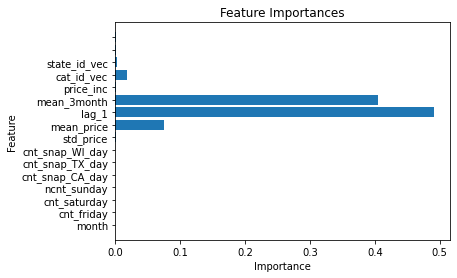

In [ ]:
# Важность признаков
importances = best_model.stages[-1].featureImportances
x_values = list(range(len(importances)))
plt.barh(x_values, importances)
plt.xlabel('Importance')
plt.yticks(x_values, FEATURES_COL)
plt.ylabel('Feature')
plt.title('Feature Importances')

## Результаты

**Linear Regression**
MAPE = 83%
MAPE взвешенный = 25%

**Random Forest**
MAPE = 143%
MAPE взвешенный = 34%